# Kaggle Avazu: Click-Through Rate Prediction

Useful insights:
----------------

* "2015 will be the year of rich data, not big data" <i><a href="http://data-informed.com/wp-content/uploads/2014/12/2015-Infographic.jpg">data-informed.com</a></i>
* "Good data scientists understand, in a deep way, that the heavy lifting of cleanup and preparation is not something that gets in the way of solving the problem: it is the problem!" <i><a href="http://fr.slideshare.net/VitalyGordon/scalable-and-flexible-machine-learning-with-scala-linkedin">DJ Patil - Founding member of the LinkedIn data science team</a></i>
* "Your first answer is unlikely to be your best answer" <i><a href="http://www.amazon.fr/Fran%C3%A7ois-Moulin/e/B008F06XU8/">F. Moulin</a></i>


In [1]:
%matplotlib inline

import numpy as np
import gzip
import cPickle as pickle
from datetime import datetime
from time import time

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

from IPython.display import display

# function to go from YYMMDDHH to a datetime object
def read_time(t):
    return datetime( int('20'+t[:2]),
                     int(t[2:4]),
                     int(t[4:6]),
                     int(t[6:]) )

Getting started:
----------------

The first to do is the following observation:    
`zcat train.gz | less`

it is a website:    
`zcat train.gz | grep "ecad2386,7801e8d9,07d7df22" | wc -l`    
`25832830`

it is an app:    
`zcat train.gz | grep "85f751fd,c4e18dd6,50e219e0" | wc -l`    
`14596137`

`zcat train.gz | wc -l`    
`40428968`

In [1]:
40428968 - (25832830 + 14596137)

1

That's the header, so all entries are either an app or a website. I do not expect users to have the same behaviour on an app and a website, so we can split them apart in order to train separate train one classifier for apps and one for websites:

Splitting the training data:
----------------------------
`zcat train.gz | head -1 | gzip > train_websites.gz`    
`zcat train.gz | head -1 | gzip > train_apps.gz`    
`zcat train.gz | grep "ecad2386,7801e8d9,07d7df22" | gzip >> train_websites.gz`    
`zcat train.gz | grep "85f751fd,c4e18dd6,50e219e0" | gzip >> train_apps.gz`   

Splitting the testing data:
---------------------------
`zcat test.gz | head -1 | gzip > test_websites.gz`    
`zcat test.gz | head -1 | gzip > test_apps.gz`    
`zcat test.gz | grep "ecad2386,7801e8d9,07d7df22" | gzip >> test_websites.gz`    
`zcat test.gz | grep "85f751fd,c4e18dd6,50e219e0" | gzip >> test_apps.gz`  

The other piece of information we shall keep at hand when looking at the data is the header:

In [8]:
f = gzip.open("data/train.gz", 'rb')
header = f.readline().rstrip().split(',')
f.close()

for i,h in enumerate(header):
    print "%02d" % i,h

00 id
01 click
02 hour
03 C1
04 banner_pos
05 site_id
06 site_domain
07 site_category
08 app_id
09 app_domain
10 app_category
11 device_id
12 device_ip
13 device_model
14 device_type
15 device_conn_type
16 C14
17 C15
18 C16
19 C17
20 C18
21 C19
22 C20
23 C21


In [31]:
f = gzip.open("data/test.gz", 'rb')
header = f.readline().rstrip().split(',')
f.close()

for i,h in enumerate(header):
    print "%02d" % i,h

00 id
01 hour
02 C1
03 banner_pos
04 site_id
05 site_domain
06 site_category
07 app_id
08 app_domain
09 app_category
10 device_id
11 device_ip
12 device_model
13 device_type
14 device_conn_type
15 C14
16 C15
17 C16
18 C17
19 C18
20 C19
21 C20
22 C21


Lastly, let's write a function returning a summary of the visits and clicks for a specific category:

In [13]:
def summarize_category(filename,c,end=None):
    f = gzip.open(filename, 'rb')
    
    header = None
    data = {}
    for line in f:
        line = line.rstrip().split(',')

        # read header
        if header is None:
            header = line
            continue
            
        if end is not None and int(line[2]) >= end:
            break

        if isinstance(c,list):
            h = ""
            for _c in c:
                h += line[_c] + "_"
        elif c == "hour":
            h = int(line[2][-2:])
        elif c == "day":
            h = read_time(line[2]).weekday()
        else:
            h = line[c]
        
        if h not in data:
            data[h] = { 'visits' : 0, 'clicks' : 0 }

        data[h]['visits'] += 1
        data[h]['clicks'] += int(line[1])
    
    res = pd.DataFrame.from_dict(data, orient='index')
    res['click_proba'] = res['clicks'] / res['visits']
    
    # order columns for plotting: there are always more visits than clicks!
    res = res.ix[:,['visits','clicks','click_proba']]
    
    return res

In [36]:
def comeback(filenames,c):
    
    days = {}
    for testing,filename in enumerate(filenames):
        f = gzip.open(filename, 'rb')
        header = None
        for line in f:
            line = line.rstrip().split(',')

            # read header
            if header is None:
                header = line
                continue

            if testing:
                d = line[1][-4:-2]
                value = line[c-1]
            else:      
                d = line[2][-4:-2]
                value = line[c]
        
            if d not in days:
                days[d] = set()
            
            days[d].add(value)
        f.close()
        
    res = np.zeros( (len(days),len(days)) )
   
    all_days = sorted(map(int,days.keys()))
    for i in range(len(days)):
        for j in range(i+1,len(days)):
            intersection = len(days[str(all_days[i])] & days[str(all_days[j])])
            res[i,j] = intersection
            res[j,i] = intersection
        
    return res

## Website popularity

,visits,clicks,click_proba
1fbe01fe_f3845767_28905ebd_,6486150,1333764,0.205633
e151e245_7e091613_f028772b_,2637747,781628,0.296324
d9750ee7_98572c79_f028772b_,963745,269965,0.280121
5b08c53b_7687a86e_3e814130_,913325,426710,0.467205
5b4d2eda_16a36ef3_f028772b_,771360,100287,0.130013


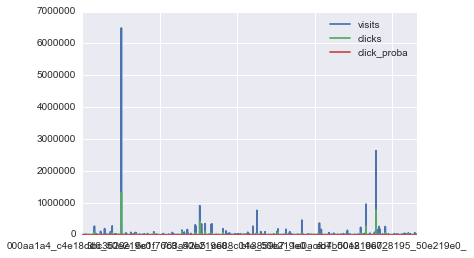

In [55]:
# website_id made of:
# 05 site_id
# 06 site_domain
# 07 site_category
website_popularity = summarize_category( "data/train_websites.gz",[5,6,7])
display(website_popularity.sort('visits',ascending=False).head())
website_popularity.plot();


## Do users come back? (12 device_ip)

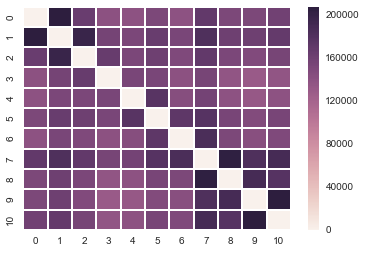

In [37]:
comeback = comeback(['data/train.gz','data/test.gz'],12)
sns.heatmap(comeback); # 10 days for training, 1 day for testing

## How do CTRs vary with time?

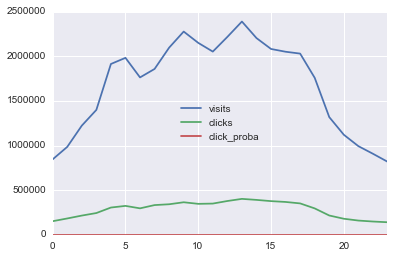

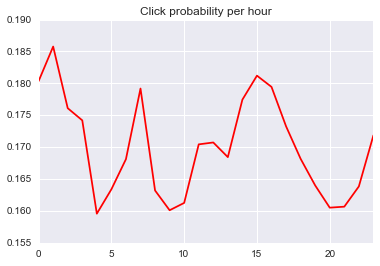

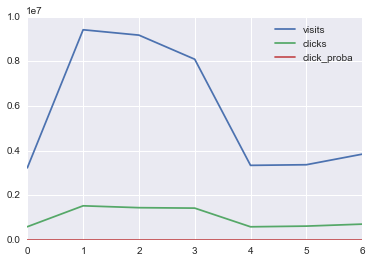

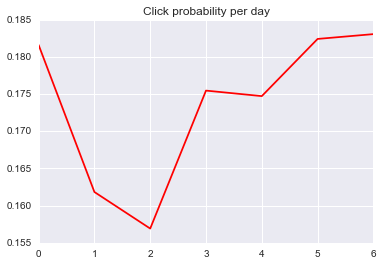

In [56]:
hours = summarize_category( 'data/train.gz', 'hour' )
hours.plot();
plt.figure()
hours['click_proba'].plot(title="Click probability per hour",color='r');
days = summarize_category( 'data/train.gz', 'day' )
days.plot();
plt.figure()
days['click_proba'].plot(title="Click probability per day",color='r');

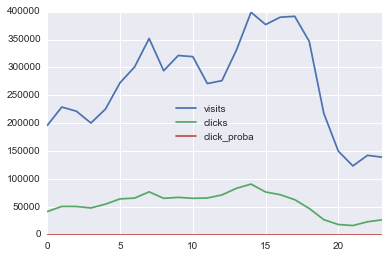

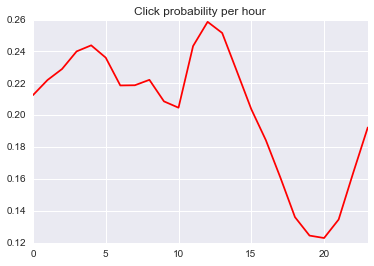

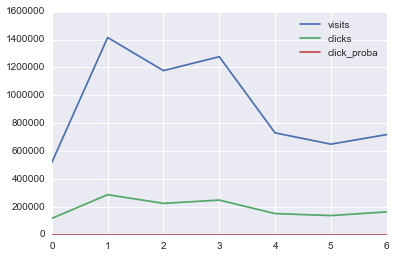

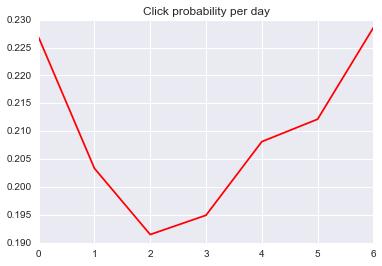

In [57]:
# is this the same as the pattern of the main website?
hours = summarize_category( 'data/train_main_website.gz', 'hour' )
hours.plot();
plt.figure()
hours['click_proba'].plot(title="Click probability per hour",color='r');
days = summarize_category( 'data/train_main_website.gz', 'day' )
days.plot();
plt.figure()
days['click_proba'].plot(title="Click probability per day",color='r');

## App popularity

,visits,clicks,click_proba
92f5800b_ae637522_0f2161f8_,1555283,30014,0.019298
e2fcccd2_5c5a694b_0f2161f8_,1129016,219689,0.194584
febd1138_82e27996_0f2161f8_,759098,36597,0.048211
9c13b419_2347f47a_f95efa07_,757812,231387,0.305336
7358e05e_b9528b13_cef3e649_,615635,115311,0.187304


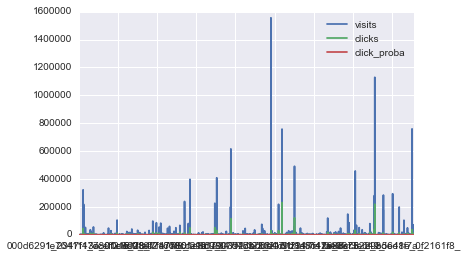

In [54]:
# app_id made of:
# 08 app_id
# 09 app_domain
# 10 app_category
app_popularity = summarize_category( "data/train_apps.gz",[8,9,10])
display(app_popularity.sort('visits',ascending=False).head())
app_popularity.plot();

## Proposed solution

 <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">GradientBoostingClassifier</a>.

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html">SGDClassifier</a>.

* Why this classifier? I was using Random Forests, then stumbled upon this <a href="http://www.csie.ntu.edu.tw/~r01922136/kaggle-2014-criteo.pdf">presentation</a> from the winner of Kaggle Criteo - Display Advertising Challenge.



Splitting the training data:
----------------------------
`zcat train.gz | head -1 | gzip > train_main_website.gz`           
`zcat train_websites.gz | grep "1fbe01fe,f3845767,28905ebd" | gzip >> train_main_website.gz`                       

`zcat train_websites.gz | grep -v "1fbe01fe,f3845767,28905ebd" | gzip > train_remaining_websites.gz`

`zcat train.gz | head -1 | gzip > train_main_app.gz`             
`zcat train_apps.gz | grep "92f5800b,ae637522,0f2161f8" | gzip >> train_main_app.gz`   
         
`zcat train_apps.gz | grep -v "92f5800b,ae637522,0f2161f8" | gzip > train_remaining_apps.gz` 

Splitting the testing data:
---------------------------
`zcat test.gz | head -1 | gzip > test_main_website.gz`           
`zcat test_websites.gz | grep "1fbe01fe,f3845767,28905ebd" | gzip >> test_main_website.gz`        

`zcat test_websites.gz | grep -v "1fbe01fe,f3845767,28905ebd" | gzip > test_remaining_websites.gz`

`zcat test.gz | head -1 | gzip > test_main_app.gz`             
`zcat test_apps.gz | grep "92f5800b,ae637522,0f2161f8" | gzip >> test_main_app.gz`   
         
`zcat test_apps.gz | grep -v "92f5800b,ae637522,0f2161f8" | gzip > test_remaining_apps.gz` 

In [3]:
def get_mapping(filename,threshold=100,testing_time=None,exclude_user=True):
    f = gzip.open(filename, 'rb')
    
    header = None
    data = [] # for each possible value of each category,
              # we record its occurence and its number of clicks
    for line in f:
        line = line.rstrip().split(',')

        # read header
        if header is None:
            header = line
            for h in header:
                data.append({})
            data.append({}) # days
            continue
            
        if testing_time is not None and int(line[2]) >= testing_time:
            break
            
        for i in range(2,len(header)): # skip id,click
            if i == 2:
                h = line[i][-2:] # hour
                d = read_time(line[2]).weekday() # day
                
                if h not in data[i]:
                    data[i][h] = { 'visits' : 0, 'clicks' : 0 }
                if d not in data[-1]:
                    data[-1][d] = { 'visits' : 0, 'clicks' : 0 }
            
                data[i][h]['clicks'] += int(line[1])
                data[i][h]['visits'] += 1
                data[-1][d]['clicks'] += int(line[1])
                data[-1][d]['visits'] += 1
                
            else:
                if line[i] not in data[i]:
                    data[i][line[i]] = { 'visits' : 0, 'clicks' : 0 }
                    
                data[i][line[i]]['clicks'] += int(line[1])
                data[i][line[i]]['visits'] += 1
                
    f.close()
    
    # we compute the click probabilities
    mapping = []
    for c in range(len(data)):
        mapping.append({})
        if (len(data[c]) < 2 and c not in [2,len(data)-1]):
            continue
        if exclude_user and (c == 11 or c == 12):
            continue
        default_visits = 0
        default_clicks = 0
        for k in data[c]:
            if data[c][k]['visits'] == 0:
                mapping[-1][k] = 0
            elif data[c][k]['visits'] < threshold:
                default_visits += data[c][k]['visits']
                default_clicks += data[c][k]['clicks']
            else:
                mapping[-1][k] = float(data[c][k]['clicks']) / float(data[c][k]['visits'])
        if default_visits > 0:
            mapping[-1]['default'] = float(default_clicks) / float(default_visits)
        elif c != 2 and c != len(data)-1: # no default for hours and days
            mapping[-1]['default'] = 0
            
    #print mapping
    
    # we sort using the click probabilities
    for i in range(len(mapping)):
        if len(mapping[i]) == 0:
            continue
        sorted_m = sorted(mapping[i].iterkeys(), key=lambda x: mapping[i][x])
        mapping[i] = dict(map(lambda x: (sorted_m[x],x),range(len(sorted_m))))
        
    return mapping

### Websites:

In [13]:
mapping = get_mapping("data/train_main_website.gz",threshold=100,testing_time=None,exclude_user=True)
#print mapping
pickle.dump(mapping,open("mapping/mapping_main_website.pk","wb"))

In [4]:
mapping = get_mapping("data/train_remaining_websites.gz",threshold=100,testing_time=None,exclude_user=True)
#print mapping
pickle.dump(mapping,open("mapping/mapping_remaining_websites.pk","wb"))

### Apps:

In [15]:
mapping = get_mapping("data/train_main_app.gz",threshold=100,testing_time=None,exclude_user=True)
#print mapping
pickle.dump(mapping,open("mapping/mapping_main_app.pk","wb"))

In [16]:
mapping = get_mapping("data/train_remaining_apps.gz",threshold=100,testing_time=None,exclude_user=True)
#print mapping
pickle.dump(mapping,open("mapping/mapping_remaining_apps.pk","wb"))

In [41]:
res = summarize_category("data/train_main_website.gz",[3,4]+range(16,24), end=14102800)

In [42]:
res.sort('visits',ascending=False).head()

,visits,clicks,click_proba
1005_0_15701_320_50_1722_0_35_-1_79_,229627,51713,0.225204
1005_0_15705_320_50_1722_0_35_-1_79_,228953,50674,0.221329
1005_0_15699_320_50_1722_0_35_-1_79_,226538,48741,0.215156
1005_0_15708_320_50_1722_0_35_-1_79_,226300,48104,0.212567
1005_0_15703_320_50_1722_0_35_-1_79_,225134,45813,0.203492


In [43]:
print np.sum(res['visits']>10)

524


In [46]:
res[res['visits']>100].sort('click_proba',ascending=False).head()

,visits,clicks,click_proba
1005_0_22503_320_50_2594_2_1327_-1_52_,679,244,0.359352
1005_0_22105_320_50_2545_3_39_100083_221_,139,44,0.316547
1005_0_21726_320_50_2502_0_39_100084_221_,200,63,0.315000
1005_0_22113_320_50_2547_2_35_100084_13_,303,94,0.310231
1005_0_20108_320_50_2299_2_1063_100084_52_,3792,1133,0.298787


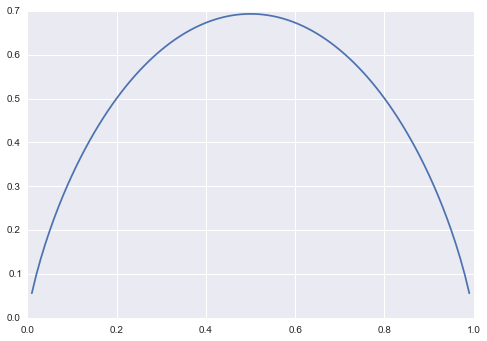

In [3]:
def f(x):
    return -( x*np.log(x)+(1-x)*np.log(1-x) )

x = np.linspace(0, 1, 100, endpoint=False)

plt.plot( x, f(x) );

In [6]:
f(0.4)

0.67301166700925652

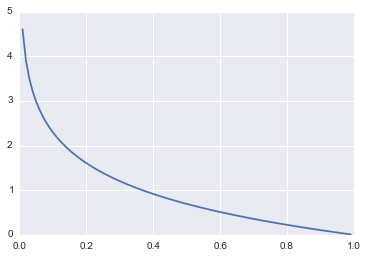

In [8]:
x = np.linspace(0, 1, 100, endpoint=False)

plt.plot( x, -np.log(x) );

In [10]:
np.exp(-0.3)

0.74081822068171788

In [12]:
np.log(0.7)

-0.35667494393873245

assume that the minimum of click_proba happens during the night, use it to put all websites/apps in the same time zone.

In [4]:
def time_shift(filename,c,end=None, test=None):
    f = gzip.open(filename, 'rb')
    
    header = None
    data = {}
    for line in f:
        line = line.rstrip().split(',')

        # read header
        if header is None:
            header = line
            continue
            
        if end is not None and int(line[2]) >= end:
            break

        k = ""
        for _c in c:
            k += line[_c] + "_"
            
        h = int(line[2][-2:])
        
        if k not in data:
            data[k] = { 'visits' : np.zeros(24,dtype='float64'),
                        'clicks' : np.zeros(24,dtype='float64') }

        data[k]['visits'][h] += 1
        data[k]['clicks'][h] += int(line[1])
        
    f.close()
        
    if test is not None:
        f = gzip.open(test, 'rb')
    
        header = None
        for line in f:
            line = line.rstrip().split(',')

            # read header
            if header is None:
                header = line
                continue

            k = ""
            for _c in c:
                k += line[_c-1] + "_"
            
            h = int(line[1][-2:])
        
            if k not in data:
                data[k] = { 'visits' : np.zeros(24,dtype='float64'),
                            'clicks' : np.zeros(24,dtype='float64') }

            data[k]['visits'][h] += 1
            
        f.close()
        
    shift = {}
    visits = np.zeros(24,dtype='float64')
    clicks = np.zeros(24,dtype='float64')
    for k in data:
        shift[k] = np.argmin(data[k]['visits'])
        for h in range(24):
            visits[(h-shift[k])%24] += data[k]['visits'][h]
            clicks[(h-shift[k])%24] += data[k]['clicks'][h]
    
    return visits, clicks, shift

In [3]:
visits, clicks, shift = time_shift( "data/train.gz",[5,6,7])

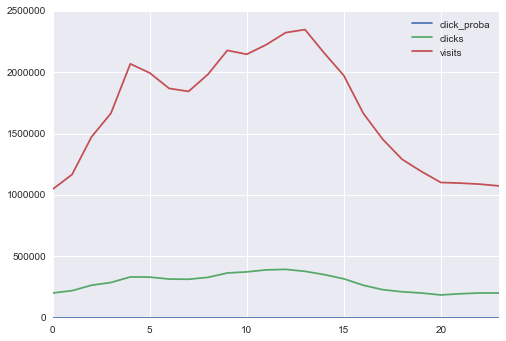

In [4]:
res = pd.DataFrame(dict(visits=visits,clicks=clicks,click_proba=clicks/visits))
res.plot()

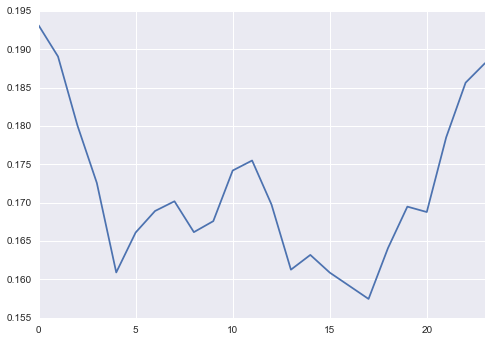

In [5]:
res['click_proba'].plot()

In [7]:
visits, clicks, shift = time_shift( "data/train_websites.gz",[5,6,7,8,9,10])

In [5]:
visits, clicks, shift = time_shift( "data/train.gz",[5,6,7,8,9,10],test="data/test.gz")
pickle.dump(shift,open("mapping/time_shift.pk","wb"))

In [4]:
pickle.dump(shift,open("mapping/time_shift.pk","wb"))

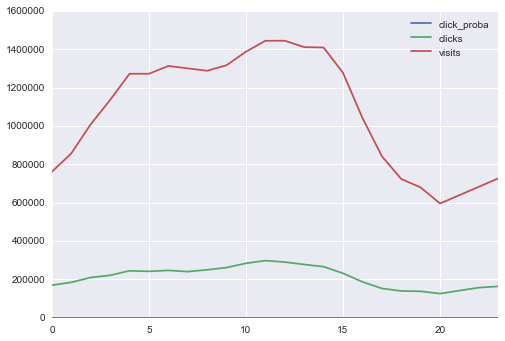

In [8]:
res = pd.DataFrame(dict(visits=visits,clicks=clicks,click_proba=clicks/visits))
res.plot()

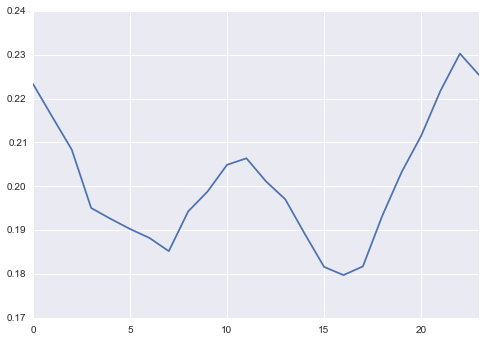

In [9]:
res['click_proba'].plot()

In [17]:
visits, clicks, shift = time_shift( "data/train_remaining_websites.gz",[5,6,7])

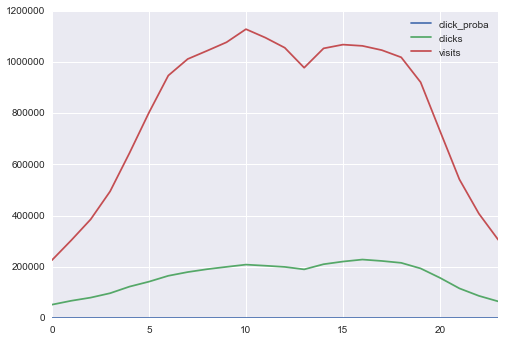

In [18]:
res = pd.DataFrame(dict(visits=visits,clicks=clicks,click_proba=clicks/visits))
res.plot()

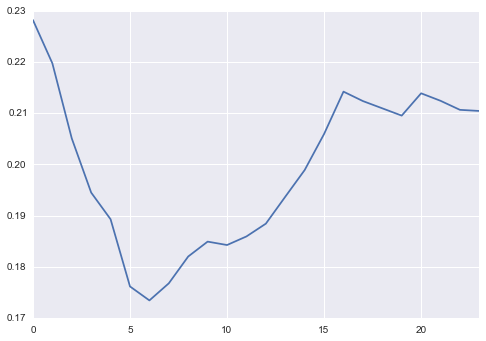

In [19]:
res['click_proba'].plot()

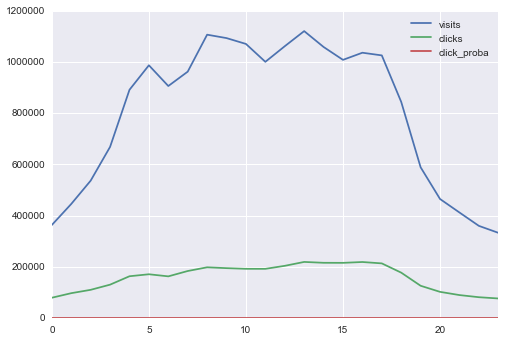

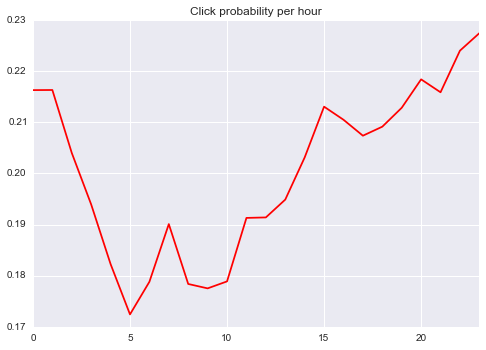

In [15]:
hours = summarize_category( 'data/train_remaining_websites.gz', 'hour' )
hours.plot();
plt.figure()
hours['click_proba'].plot(title="Click probability per hour",color='r');

In [3]:
def get_mapping(filename,threshold=100,testing_time=None,exclude_user=True):
    f = gzip.open(filename, 'rb')
    
    header = None
    data = [] # for each possible value of each category,
              # we record its occurence and its number of clicks
    for line in f:
        line = line.rstrip().split(',')

        # read header
        if header is None:
            header = line
            for h in header:
                data.append({})
            data.append({}) # days
            continue
            
        if testing_time is not None and int(line[2]) >= testing_time:
            break
            
        for i in range(2,len(header)): # skip id,click
            if i == 2:
                h = line[i][-2:] # hour
                d = read_time(line[2]).weekday() # day
                
                if h not in data[i]:
                    data[i][h] = { 'visits' : 0, 'clicks' : 0 }
                if d not in data[-1]:
                    data[-1][d] = { 'visits' : 0, 'clicks' : 0 }
            
                data[i][h]['clicks'] += int(line[1])
                data[i][h]['visits'] += 1
                data[-1][d]['clicks'] += int(line[1])
                data[-1][d]['visits'] += 1
                
            else:
                if line[i] not in data[i]:
                    data[i][line[i]] = { 'visits' : 0, 'clicks' : 0 }
                    
                data[i][line[i]]['clicks'] += int(line[1])
                data[i][line[i]]['visits'] += 1
                
    f.close()
    
    # we compute the click probabilities
    mapping = []
    for c in range(len(data)):
        mapping.append({})
        if (len(data[c]) < 2 and c not in [2,len(data)-1]):
            continue
        if exclude_user and (c == 11 or c == 12):
            continue
        default_visits = 0
        default_clicks = 0
        for k in data[c]:
            if data[c][k]['visits'] == 0:
                mapping[-1][k] = 0
            else:
                mapping[-1][k] = float(data[c][k]['clicks']) #/ float(data[c][k]['visits']))
            mapping[-1]['default'] = 0
            
    #print mapping
    
    # we sort using the click probabilities
    for i in range(len(mapping)):
        if len(mapping[i]) == 0:
            continue
        sorted_m = sorted(mapping[i].iterkeys(), key=lambda x: mapping[i][x])
        mapping[i] = dict(map(lambda x: (sorted_m[x],x),range(len(sorted_m))))
        
    return mapping

In [5]:
mapping = get_mapping("data/train_main_website.gz",threshold=100,testing_time=14102800,exclude_user=True)
#print mapping
pickle.dump(mapping,open("mapping_main_website_pxy.pk","wb"))